# Retail Sales Forecasting using Time-Series Models

## Introduction

Retail businesses rely on accurate sales forecasts to manage inventory, staffing, and revenue planning. Traditional forecasting methods often fail to capture seasonality, holidays, promotions, and sudden demand fluctuations, which can lead to overstocking or stockouts.

This project analyzes historical retail sales data and builds multiple time-series forecasting models — ARIMA, Prophet, and LSTM — to predict weekly sales for different stores and departments. The models are compared using performance metrics (MAPE and RMSE) to identify the most accurate forecasting approach.

An interactive dashboard is deployed using Streamlit to visualize historical trends, forecasted sales, and model performance, enabling data-driven business decisions.

Key Highlights:

Time-series forecasting with ARIMA, Prophet, and LSTM.

Incorporation of holiday effects and external features.

Performance comparison using MAPE and RMSE.

Streamlit dashboard for interactive visualization and business insights.

## Step 1: Load and Explore the Dataset (EDA)

### Objective:
Understand the data, check for missing values, data types, trends, and seasonal patterns. This is the foundation before building any forecasting model.

### Files we have:

* sales.csv → main weekly sales data.

* features.csv → external factors like holidays, markdowns, CPI, etc.

* train.csv → training set.

* test.csv → test set for evaluation.

### Why this step is important:

* Ensures the dataset is clean and consistent.

* Helps visualize trends (seasonality, holidays, spikes).

* Guides feature selection for models, especially LSTM or Prophet which can use external regressors.

### Actions in this step:

* Load CSV files using pandas.

* Merge sales with features on Store + Date.

* Convert Date column to datetime and sort.

* Check data info: missing values, column types.

* Explore basic statistics: mean, median, min, max of sales.

* Visualize:

    * Overall sales trend (line plot).

    * Sales per store/department.

    * Highlight holidays and seasonal effects.

In [112]:
# Step 0: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [113]:
# Step 1: Load CSV files
stores = pd.read_csv("stores.csv")
features = pd.read_csv("features.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [114]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [115]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [116]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [117]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [118]:
# Step 3: Merge train with features
data = pd.merge(train, features, on=["Store", "Date"], how="left")

In [119]:
# Step 4: Convert 'Date' to datetime and sort
data['Date'] = pd.to_datetime(data['Date'])

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  IsHoliday_y   421570 non-null  bool          
dtypes: bool(2), datet

In [121]:
data.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
dtype: int64

In [122]:
data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


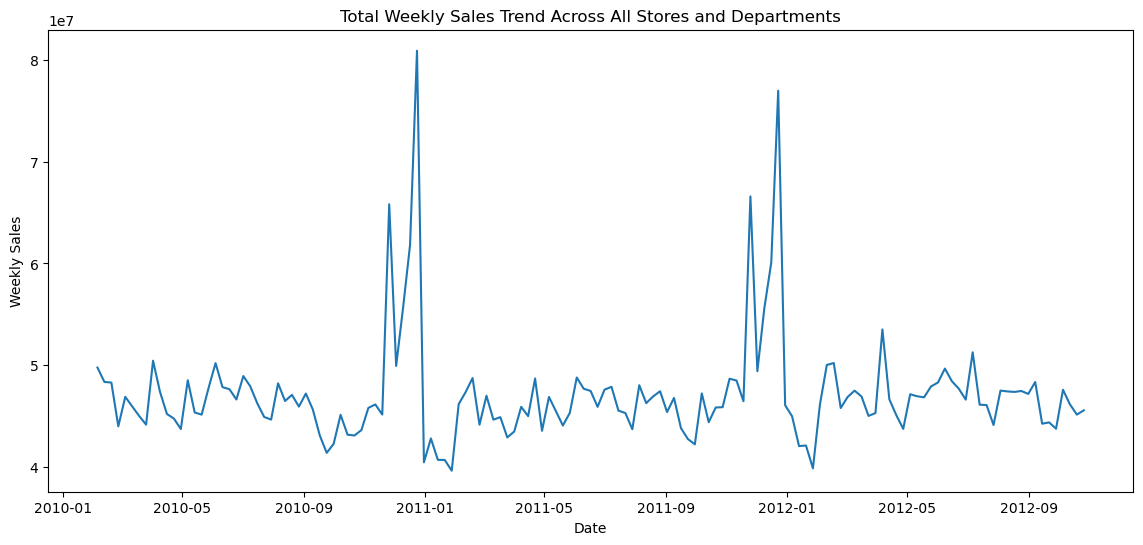

In [93]:
# Visualize total weekly sales

plt.figure(figsize=(14,6))
total_sales = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
sns.lineplot(x='Date',y='Weekly_Sales',data=total_sales)
plt.title("Total Weekly Sales Trend Across All Stores and Departments")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

In [123]:
# Fix duplicate holiday column
data = data.drop(columns=['IsHoliday_x'])
data.rename(columns={'IsHoliday_y':'IsHoliday'}, inplace=True)
data['IsHoliday'] = data['IsHoliday'].astype(int)

In [124]:
# Fill missing MarkDowns with 0
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
data[markdown_cols] = data[markdown_cols].fillna(0)

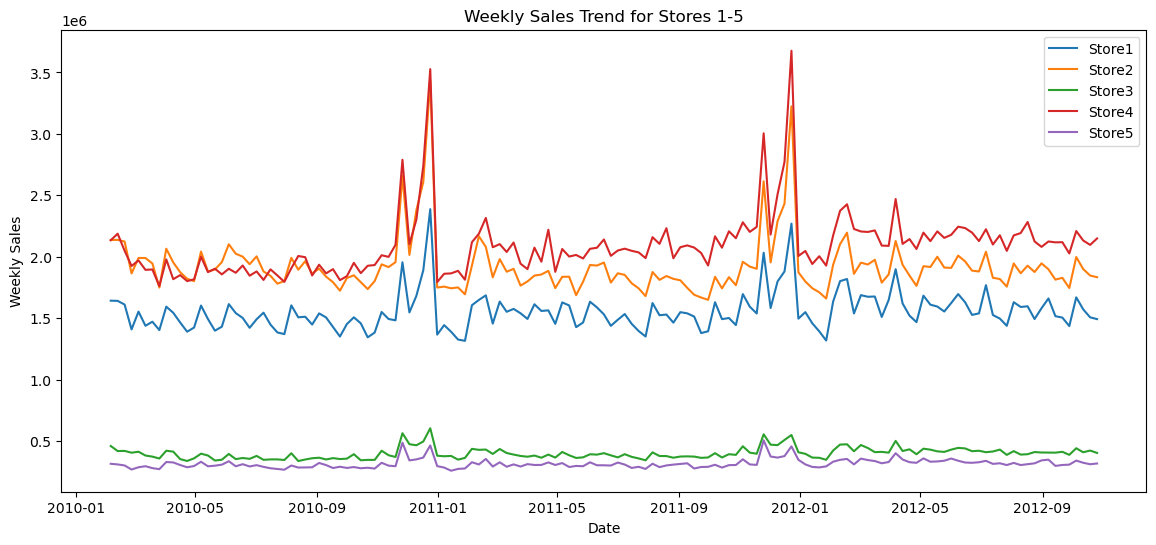

In [125]:
# Visualize sales for first 5 stores
plt.figure(figsize=(14,6))
for store_id in range(1,6):
    store_sales = data[data['Store']==store_id].groupby('Date')['Weekly_Sales'].sum().reset_index()
    plt.plot(store_sales['Date'],store_sales['Weekly_Sales'],label=f"Store{store_id}")
plt.title("Weekly Sales Trend for Stores 1-5")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()
    

In [127]:
# Step 4: Aggregate weekly sales per store (Store 1)
store1 = data[data['Store']==1].groupby('Date')['Weekly_Sales'].sum().reset_index()
store1 = store1.rename(columns={'Date':'ds','Weekly_Sales':'y'})
store1['ds'] = pd.to_datetime(store1['ds'])

In [128]:
# Step 5: Train/Test Split
train_store1 = store1[store1['ds'] < '2012-01-01']
test_store1 = store1[store1['ds'] >= '2012-01-01']

In [129]:
print(f"Train range: {train_store1['ds'].min()} to {train_store1['ds'].max()}")
print(f"Test range: {test_store1['ds'].min()} to {test_store1['ds'].max()}")

Train range: 2010-02-05 00:00:00 to 2011-12-30 00:00:00
Test range: 2012-01-06 00:00:00 to 2012-10-26 00:00:00


In [130]:
# Step 6: Initialize and fit Prophet
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_store1)

08:55:17 - cmdstanpy - INFO - Chain [1] start processing
08:55:17 - cmdstanpy - INFO - Chain [1] done processing


In [131]:
# Step 7: Forecast on exact test dates
future = pd.DataFrame({'ds': test_store1['ds']})
forecast = model.predict(future)

In [132]:
# Step 8: Merge forecast with actuals
forecast_test = forecast[['ds','yhat']].merge(test_store1, on='ds')


In [133]:
# Step 9: Evaluate Accuracy
rmse = np.sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))
mape = np.mean(np.abs((forecast_test['y'] - forecast_test['yhat']) / forecast_test['y'])) * 100


In [134]:
print(f"Corrected RMSE: {rmse:,.2f}")
print(f"Corrected MAPE: {mape:.2f}%")

Corrected RMSE: 98,810.08
Corrected MAPE: 4.66%


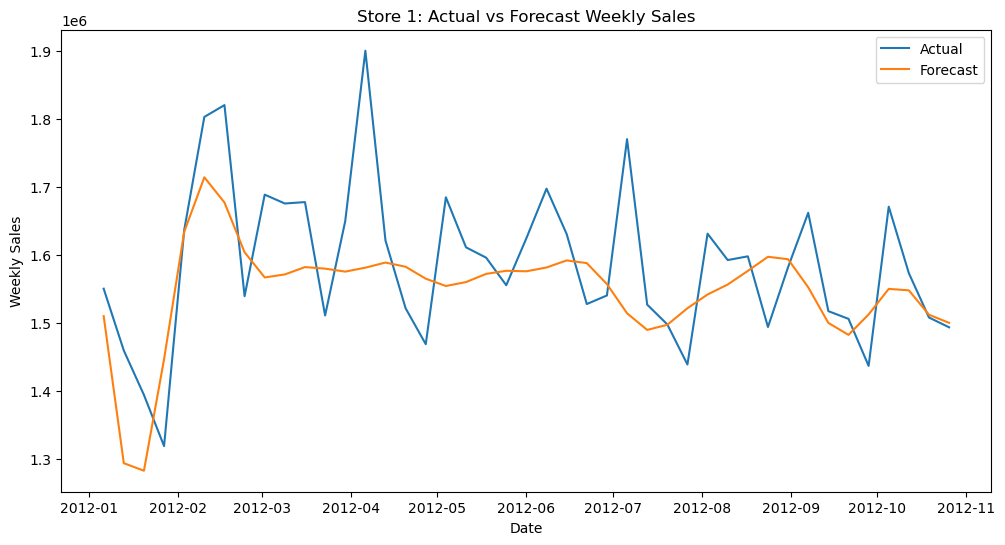

In [135]:
# Step 10: Plot Forecast vs Actual
plt.figure(figsize=(12,6))
plt.plot(forecast_test['ds'], forecast_test['y'], label='Actual')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast')
plt.title("Store 1: Actual vs Forecast Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

## Enhance the Prophet model by adding holidays as regressors

### Step 1: Prepare Holidays Dataframe

In [136]:
# Prophet requires a specific format for holidays:
# Extract all holiday dates from training data
holidays_df = data[data['IsHoliday']==1][['Date']].drop_duplicates()
holidays_df = holidays_df.rename(columns={'Date':'ds'})
holidays_df['holiday'] = 'holiday'  # Name of holiday


### Step 2: Initialize Prophet with Holidays

In [137]:
# Initialize Prophet with yearly & weekly seasonality + holidays
model_holiday = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    holidays=holidays_df
)

# Fit on aggregated store-level weekly sales (Store 1)
model_holiday.fit(train_store1)


09:01:03 - cmdstanpy - INFO - Chain [1] start processing
09:01:03 - cmdstanpy - INFO - Chain [1] done processing


### Step 3: Forecast on Test Dates

In [138]:
future = pd.DataFrame({'ds': test_store1['ds']})
forecast = model_holiday.predict(future)

# Merge with actuals
forecast_test = forecast[['ds','yhat']].merge(test_store1, on='ds')


### Step 4: Evaluate Accuracy

In [139]:
rmse = np.sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))
mape = np.mean(np.abs((forecast_test['y'] - forecast_test['yhat']) / forecast_test['y'])) * 100

print(f"RMSE with Holidays: {rmse:,.2f}")
print(f"MAPE with Holidays: {mape:.2f}%")


RMSE with Holidays: 98,590.50
MAPE with Holidays: 4.66%


### Step 5: Loop Through All Stores

In [140]:
store_rmse = {}
store_mape = {}

for store_id in data['Store'].unique():
    # Aggregate weekly sales for each store
    store_df = data[data['Store']==store_id].groupby('Date')['Weekly_Sales'].sum().reset_index()
    store_df = store_df.rename(columns={'Date':'ds','Weekly_Sales':'y'})
    store_df['ds'] = pd.to_datetime(store_df['ds'])
    
    train_store = store_df[store_df['ds'] < '2012-01-01']
    test_store = store_df[store_df['ds'] >= '2012-01-01']
    
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=holidays_df)
    model.fit(train_store)
    
    future = pd.DataFrame({'ds': test_store['ds']})
    forecast = model.predict(future)
    
    forecast_test = forecast[['ds','yhat']].merge(test_store, on='ds')
    
    rmse = np.sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))
    mape = np.mean(np.abs((forecast_test['y'] - forecast_test['yhat']) / forecast_test['y'])) * 100
    
    store_rmse[store_id] = rmse
    store_mape[store_id] = mape

# Check results
print("Store-wise RMSE:", store_rmse)
print("Store-wise MAPE:", store_mape)


09:02:28 - cmdstanpy - INFO - Chain [1] start processing
09:02:28 - cmdstanpy - INFO - Chain [1] done processing
09:02:29 - cmdstanpy - INFO - Chain [1] start processing
09:02:29 - cmdstanpy - INFO - Chain [1] done processing
09:02:29 - cmdstanpy - INFO - Chain [1] start processing
09:02:29 - cmdstanpy - INFO - Chain [1] done processing
09:02:29 - cmdstanpy - INFO - Chain [1] start processing
09:02:29 - cmdstanpy - INFO - Chain [1] done processing
09:02:30 - cmdstanpy - INFO - Chain [1] start processing
09:02:30 - cmdstanpy - INFO - Chain [1] done processing
09:02:30 - cmdstanpy - INFO - Chain [1] start processing
09:02:30 - cmdstanpy - INFO - Chain [1] done processing
09:02:30 - cmdstanpy - INFO - Chain [1] start processing
09:02:31 - cmdstanpy - INFO - Chain [1] done processing
09:02:31 - cmdstanpy - INFO - Chain [1] start processing
09:02:31 - cmdstanpy - INFO - Chain [1] done processing
09:02:31 - cmdstanpy - INFO - Chain [1] start processing
09:02:31 - cmdstanpy - INFO - Chain [1]

Store-wise RMSE: {1: 98590.50085081963, 2: 183108.41449880306, 3: 33717.32389301665, 4: 107580.80469608841, 5: 21002.15774642518, 6: 123963.18152804032, 7: 55602.59129936582, 8: 44436.72229047242, 9: 31282.332275120363, 10: 117733.04785676161, 11: 79743.6643334102, 12: 51647.75361492589, 13: 105050.58886096114, 14: 197958.80963663786, 15: 42714.34145006768, 16: 34829.451269558616, 17: 75402.54476155178, 18: 181014.96564908457, 19: 85122.59235455813, 20: 145873.03076527585, 21: 55111.08052386795, 22: 65143.804711566416, 23: 90797.87368516973, 24: 97076.17037994185, 25: 57437.945569870666, 26: 51461.11090011668, 27: 111738.90929603309, 28: 124111.9737963467, 29: 42474.9054638676, 30: 43259.06253223533, 31: 86461.17445873324, 32: 46997.093102327024, 33: 19671.536650459744, 34: 48629.89418439317, 35: 174798.10482916055, 36: 33485.72759203117, 37: 16708.426515745607, 38: 32689.80111795774, 39: 80393.90292755977, 40: 63285.75540695889, 41: 56329.249091167156, 42: 51351.59381717085, 43: 59291

## loop to forecast all stores using Prophet (with holidays)

### Forecast All Stores

In [142]:
all_forecasts = []  # To store forecasts for all stores

for store_id in data['Store'].unique():
    # Aggregate weekly sales for the store
    store_df = data[data['Store']==store_id].groupby('Date')['Weekly_Sales'].sum().reset_index()
    store_df = store_df.rename(columns={'Date':'ds','Weekly_Sales':'y'})
    store_df['ds'] = pd.to_datetime(store_df['ds'])
    
    # Split train/test
    train_store = store_df[store_df['ds'] < '2012-01-01']
    test_store = store_df[store_df['ds'] >= '2012-01-01']
    
    # Initialize Prophet with holidays
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=holidays_df)
    model.fit(train_store)
    
    # Create future dataframe for test dates
    future = pd.DataFrame({'ds': test_store['ds']})
    forecast = model.predict(future)
    
    # Combine forecast with store ID
    forecast['Store'] = store_id
    forecast = forecast[['Store','ds','yhat']]
    
    # Append to final list
    all_forecasts.append(forecast)

# Concatenate all store forecasts into one dataframe
final_forecast = pd.concat(all_forecasts, ignore_index=True)
final_forecast.head()


09:05:21 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
09:05:22 - cmdstanpy - INFO - Chain [1] done processing
09:05:23 - cmdstanpy - INFO - Chain [1] start processing
09:05:23 - cmdstanpy - INFO - Chain [1] done processing
09:05:23 - cmdstanpy - INFO - Chain [1] start processing
09:05:23 - cmdstanpy - INFO - Chain [1] done processing
09:05:23 - cmdstanpy - INFO - Chain [1] start processing
09:05:23 - cmdstanpy - INFO - Chain [1]

,Store,ds,yhat
0,1,2012-01-06,1.500428e+06
1,1,2012-01-13,1.291128e+06
2,1,2012-01-20,1.285919e+06
3,1,2012-01-27,1.448979e+06
4,1,2012-02-03,1.630085e+06


In [161]:
from prophet import Prophet
import pandas as pd

all_forecasts = []

for store_id in df['Store'].unique():
    # Prepare training data aggregated across departments
    train_store = df[df['Store']==store_id].groupby('Date')['Weekly_Sales'].sum().reset_index()
    train_store = train_store.rename(columns={'Date':'ds','Weekly_Sales':'y'})
    
    # Fit Prophet
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    model.fit(train_store)
    
    # Prepare test dates (just dates)
    test_store = test[test['Store']==store_id].copy()
    test_store['ds'] = pd.to_datetime(test_store['Date'])
    future = pd.DataFrame({'ds': test_store['ds']})
    
    # Forecast
    forecast = model.predict(future)
    
    # Aggregate yhat if needed (in case of duplicates per store)
    forecast = forecast.groupby('ds')['yhat'].sum().reset_index()
    
    # Add store column
    forecast['Store'] = store_id
    forecast = forecast[['Store','ds','yhat']]
    
    all_forecasts.append(forecast)

# Combine all stores
final_forecast_df = pd.concat(all_forecasts).reset_index(drop=True)

# Rename yhat for clarity
final_forecast_df = final_forecast_df.rename(columns={'yhat':'Predicted_Weekly_Sales'})


09:28:50 - cmdstanpy - INFO - Chain [1] start processing
09:28:50 - cmdstanpy - INFO - Chain [1] done processing
09:28:50 - cmdstanpy - INFO - Chain [1] start processing
09:28:51 - cmdstanpy - INFO - Chain [1] done processing
09:28:51 - cmdstanpy - INFO - Chain [1] start processing
09:28:51 - cmdstanpy - INFO - Chain [1] done processing
09:28:52 - cmdstanpy - INFO - Chain [1] start processing
09:28:52 - cmdstanpy - INFO - Chain [1] done processing
09:28:53 - cmdstanpy - INFO - Chain [1] start processing
09:28:53 - cmdstanpy - INFO - Chain [1] done processing
09:28:53 - cmdstanpy - INFO - Chain [1] start processing
09:28:53 - cmdstanpy - INFO - Chain [1] done processing
09:28:54 - cmdstanpy - INFO - Chain [1] start processing
09:28:54 - cmdstanpy - INFO - Chain [1] done processing
09:28:55 - cmdstanpy - INFO - Chain [1] start processing
09:28:55 - cmdstanpy - INFO - Chain [1] done processing
09:28:55 - cmdstanpy - INFO - Chain [1] start processing
09:28:55 - cmdstanpy - INFO - Chain [1]

In [154]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [157]:
final_forecast_df.head()

,Store,ds,Predicted_Weekly_Sales
0,1,2012-11-02,1.576805e+06
1,1,2012-11-02,1.576805e+06
2,1,2012-11-02,1.576805e+06
3,1,2012-11-02,1.576805e+06
4,1,2012-11-02,1.576805e+06


In [162]:
train_store = df[df['Store']==store_id].groupby('Date')['Weekly_Sales'].sum().reset_index()
train_store = train_store.rename(columns={'Date':'ds','Weekly_Sales':'y'})


2025-09-26 09:53:08.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 09:53:08.570 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 09:53:08.570 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 09:53:08.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 09:53:08.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 09:53:08.579 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 09:53:08.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 09:53:08.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

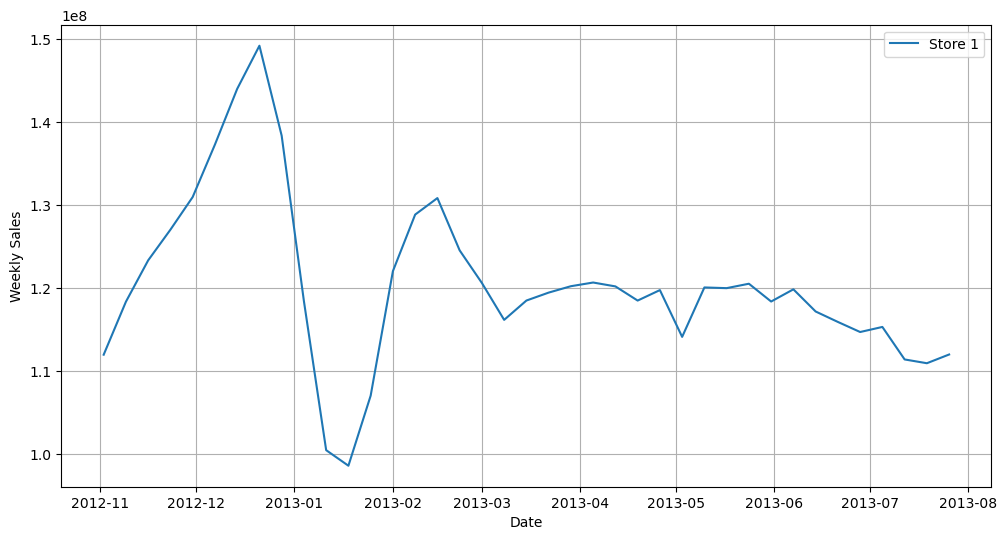

In [164]:
import streamlit as st
import matplotlib.pyplot as plt

st.title("Retail Sales Forecast Dashboard")

# Sidebar store filter
stores = final_forecast_df['Store'].unique()
selected_stores = st.sidebar.multiselect("Select Store(s)", options=stores, default=stores[0])

# Filter data
filtered_df = final_forecast_df[final_forecast_df['Store'].isin(selected_stores)]

# Plot predicted sales
st.subheader("Predicted Weekly Sales")
plt.figure(figsize=(12,6))
for store in selected_stores:
    store_data = filtered_df[filtered_df['Store']==store]
    plt.plot(store_data['ds'], store_data['Predicted_Weekly_Sales'], label=f"Store {store}")

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
st.pyplot(plt)

# Optional: Highlight holidays
st.subheader("Holiday Effect")
highlight_holidays = st.checkbox("Highlight Holidays", value=True)
if highlight_holidays:
    # Example: mark weeks where test 'IsHoliday' is True
    holidays_df = test[test['IsHoliday']==True]
    st.write("Holiday Weeks:")
    st.dataframe(holidays_df[['Store','Date']])


In [151]:
pip install streamlit

     ---------------------------------------- 10.1/10.1 MB 3.8 MB/s eta 0:00:00
     -------------------------------------- 731.2/731.2 kB 9.2 MB/s eta 0:00:00
     -------------------------------------- 435.7/435.7 kB 9.1 MB/s eta 0:00:00
     ---------------------------------------- 26.2/26.2 MB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 6.9/6.9 MB 3.2 MB/s eta 0:00:00
     -------------------------------------- 208.2/208.2 kB 6.4 MB/s eta 0:00:00
     -------------------------------------- 407.3/407.3 kB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 44.6/44.6 kB ? eta 0:00:00
     ---------------------------------------- 62.8/62.8 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.0.1
    Uninstal

In [166]:
final_forecast_df.to_csv("final_forecast_df.csv", index=False)
